### Black Box Attacks and Defenses 

### Experiment 2 

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models 

import numpy as np

from art.estimators.classification import PyTorchClassifier

from PIL import Image
from torchvision import transforms

In [2]:
import ast 
import pandas as pd 

In [3]:
import matplotlib.pyplot as plt 
import pretrainedmodels 

from datetime import datetime ## important 
import time 
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
torch.cuda.set_device(1)
torch.cuda.current_device()

1

#### Attacks from ART 

In [5]:
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import NewtonFool 
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import SimBA
from art.attacks.evasion import BoundaryAttack 
from art.attacks.evasion import HopSkipJump

In [6]:
from skimage.metrics import structural_similarity as ssim

#### Some methods and variables 

In [7]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
def softmax_activation(inputs): 
    inputs = inputs.tolist()
    exp_values = np.exp(inputs - np.max(inputs)) 
    
    # Normalize 
    probabilities = exp_values / np.sum(exp_values)
    return probabilities

In [9]:
def compare_images(imageA, imageB):
    return 1 - ssim(imageA, imageB, multichannel=True)

In [10]:
def calc_L_dist(adv_map, targ_map):
    n = len(adv_map)
    l1_dist = np.linalg.norm(adv_map.reshape((n, -1)) - targ_map.reshape((n, -1)), 1, axis=1) 
    
    l1_dist = l1_dist[0]/(224*224)
    return l1_dist

In [11]:
### Variables 
DATA_DIR = "data/imagenetv2/imagenetv2-top-images-format-val"
# selected_images_file_path = 'data/exp2_1000_images_paths_filter65.txt'
selected_images_file_path = "data/exp2_200_images_paths_filter65.txt"

#### Loading images selected image paths 

In [12]:
selected_images_list_file = open(selected_images_file_path, "r")
loaded_image_paths_list = selected_images_list_file.read()

### Converst file content into list using ast
loaded_image_paths_list = ast.literal_eval(loaded_image_paths_list)

In [13]:
len(loaded_image_paths_list)

200

### Main method

In [14]:
def experiment1_method(target_classifier, attack, image_list): 
    column_list = ['image', 'benign_pred', 'benign_conf', 'adv_pred', 'adv_conf', 'attack_time', 'noise_ratio'] 
    results_df =  pd.DataFrame(columns = column_list) 
    
    for image in image_list: 
        input_image = Image.open(DATA_DIR + image)
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0).numpy().astype(np.float32)
        
        preds = target_classifier.predict(input_batch)  
        predicted_label = np.argmax(preds, axis=1)[0] 
        
        confidence = round(np.max(softmax_activation(preds), axis=1)[0], 3) 
        
        ## attack 
        start = time.time() 
        adv_image = attack.generate(x=input_batch)
        attack_time = time.time()-start 
        
        noise_ratio = compare_images(input_batch[0].transpose(1,2,0), adv_image[0].transpose(1,2,0))
        noise_ratio = round(noise_ratio, 5) 
        
        l1_distance = calc_L_dist(adv_image, input_batch)
        
        adv_prediction = target_classifier.predict(adv_image)  
        adv_predicted_label = np.argmax(adv_prediction, axis=1)[0] 
        adv_confidence = round(np.max(softmax_activation(adv_prediction), axis=1)[0], 3)  
        
        results_df = results_df.append({'image': image, 
                                       'benign_pred': predicted_label, 
                                       'benign_conf': confidence, 
                                       'adv_pred': adv_predicted_label,
                                       'adv_conf': adv_confidence, 
                                       'attack_time': attack_time, 
                                       'noise_ratio': noise_ratio, 
                                       'l1_distance': l1_distance}, ignore_index=True)
    return results_df

In [15]:
def summarize_result(results, total_images):
    avg_benign_conf = round(results['benign_conf'].mean(), 3)
    benign_conf_std = round(results['benign_conf'].std(), 3)
    
    attack_success_count = results[results.benign_pred != results.adv_pred]["image"].count()
    attack_failure_count = total_images - attack_success_count 
    
    avg_adv_success_conf = round(results[results.benign_pred != results.adv_pred]["adv_conf"].mean(), 3) 
    adv_success_conf_std = round(results[results.benign_pred != results.adv_pred]["adv_conf"].std(), 3) 
    
    avg_adv_fail_conf = round(results[results.benign_pred == results.adv_pred]["adv_conf"].mean(), 3) 
    adv_fail_conf_std = round(results[results.benign_pred == results.adv_pred]["adv_conf"].std(), 3) 
    
    avg_attack_time = round(results['attack_time'].mean(), 4) 
    attack_time_std = round(results['attack_time'].std(), 4) 
    
    avg_noise_ratio = round(results['noise_ratio'].mean(), 5) 
    noise_ratio_std = round(results['noise_ratio'].std(), 5)
    
    avg_l1_distance = round(results['l1_distance'].mean(), 5)      
    l1_distance_std = round(results['l1_distance'].std(), 5)  
    
    
    print("Benign average confidence: {} ± {}".format(avg_benign_conf, benign_conf_std))
    print("Attack success rate: {}/200 ({}±{})".format(attack_success_count, avg_adv_success_conf, adv_success_conf_std))
    print("Attack failure rate: {}/200 ({}±{})".format(attack_failure_count, avg_adv_fail_conf, adv_fail_conf_std))
    print("Average attack time: {} ± {}".format(avg_attack_time, attack_time_std))
    print("Average noise ratio: {} ± {}".format(avg_noise_ratio, noise_ratio_std))    
    print("Average l1 distance: {} ± {}".format(avg_l1_distance, l1_distance_std))  
    print("===================================")

In [21]:
model_name = 'xception' 
model_xception = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

resnet152 = models.resnet152(pretrained=True)  
vgg19 = models.vgg19(pretrained=True)
densenet161 = models.densenet161(pretrained=True)
mobilenetv2 = models.mobilenet_v2(pretrained=True)  
googlenet = models.googlenet(pretrained=True)  
inceptionv3 = models.inception_v3(pretrained=True) 

In [22]:
target_models_list = [inceptionv3, model_xception, googlenet, mobilenetv2] 
# vgg19, resnet152, densenet161, 

# "vgg19", "resnet152", "densenet161", 
target_models_names = [ "inceptionv3", "model_xception", "googlenet", "mobilenetv2"] 

In [ ]:
for i in range(0, len(target_models_list)): 
    criterion = nn.CrossEntropyLoss()

    # Create the ART classifier
    classifier = PyTorchClassifier(
        model=target_models_list[i],
        loss=criterion,
        input_shape=(3, 224, 224),
        nb_classes=1000,
        device_type='cuda:2'
    )
    boundary_attack = BoundaryAttack(estimator = classifier, epsilon=0.01, max_iter=1000, targeted=False, verbose=False)
#     pgd_attack = ProjectedGradientDescent(classifier, max_iter=20, eps_step=1, eps=0.01) 
#     fgsm_attack = FastGradientMethod(estimator = classifier, eps=0.01)
#     newton_attack = NewtonFool(classifier=classifier, max_iter=5, verbose=False) 
#     attack_simba = SimBA(classifier=classifier, epsilon = 0.05, max_iter=5000)
#     cw_attack = CarliniL2Method(classifier=classifier, max_iter=2, learning_rate=0.05, verbose=False)
#     hopskipjump_attack = HopSkipJump(classifier=classifier, max_iter=20, verbose=False)
    result_table = experiment1_method(classifier, boundary_attack, loaded_image_paths_list)  
    
    
    result_table.to_csv("exp2_results/{}_boundary_attack.csv".format(target_models_names[i]), index=False)
    print("Target model: {}".format(target_models_names[i]))
    summarize_result(result_table, 200)

Target model: inceptionv3
Benign average confidence: 0.986 ± 0.045
Attack success rate: 138/200 (0.468±0.06)
Attack failure rate: 62/200 (0.462±0.065)
Average attack time: 204.2199 ± 45.6419
Average noise ratio: 0.05664 ± 0.0683
Average l1 distance: 0.04603 ± 0.03454


### Test

In [ ]:
res = pd.read_csv("exp2_results/inceptionv3_boundary_attack.csv")
summarize_result(res, 200)

In [75]:
criterion = nn.CrossEntropyLoss()

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model_densenet161,
    loss=criterion,
    input_shape=(3, 224, 224),
    nb_classes=1000,
    device_type='gpu'
)

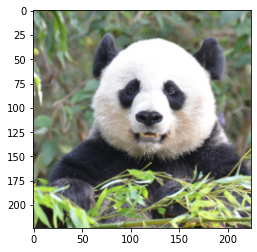

In [107]:
input_image = Image.open(DATA_DIR + '/388/3.jpeg')

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).numpy().astype(np.float32)

input = input_batch[0].transpose((1,2,0))
plt.imshow(input)

In [112]:
# res = calculate_IoU_score(input_batch[0], x_test_adv[0])

(3, 224, 224)


In [108]:
preds = classifier.predict(input_batch)
print(np.argmax(preds, axis=1))

accuracy = np.max(softmax_activation(preds), axis=1)
accuracy = round(accuracy[0], 2)
print("Accuracy on benign examples: {}%".format(accuracy * 100))

[388]
Accuracy on benign examples: 99.0%


### Attack 

In [109]:
fgsm_attack = FastGradientMethod(estimator = classifier, eps=0.05)
# newton_attack = NewtonFool(classifier=classifier, max_iter=50, verbose=False)  
cw_attack = CarliniL2Method(classifier=classifier, max_iter=2, learning_rate=0.05, verbose=True)
# attack_simba = SimBA(classifier=classifier, epsilon = 0.05, max_iter=5000) # .0025, 10K  

start = time.time()
x_test_adv = fgsm_attack.generate(x=input_batch)
print(time.time()-start) 

predictions = classifier.predict(x_test_adv)
print(np.argmax(predictions, axis=1))

# accuracy = np.max(predictions, axis=1)

accuracy = round(np.max(softmax_activation(predictions), axis=1)[0]*100,2)
print("Accuracy on adversarial test examples: {}%".format(accuracy))

1.0177359580993652
[294]
Accuracy on adversarial test examples: 43.45%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


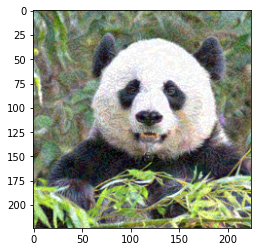

In [110]:
input = x_test_adv[0].transpose((1,2,0))
plt.imshow(input)